# FACT-UVA: Man is to Programmer as Woman is to Homemaker?

## Links

Debiaswe: https://github.com/tolga-b/debiaswe
Lipstick: https://github.com/gonenhila/gender_bias_lipstick

### How to get the GoogleNews word2vec embeddings:
Download it directly from the official [website](https://code.google.com/archive/p/word2vec/) or clone [this github repo](https://github.com/mmihaltz/word2vec-GoogleNews-vectors). Place the downloaded **.bin** file in the embeddings folder.

### How to get the Glove embeddings:
Go to the official [website](https://nlp.stanford.edu/projects/glove/). Download **glove.840B.300d.zip**. Place the downloaded **.txt** file in the embeddings folder.

## Debiasing Word Embeddings

### Word2vec

The code block bellow executes the main debias function using the word2vec Google News embeddings. Additionally, the function takes as arugments several json files with definitional pairs and geneder specific words as described in the original paper. The function outputs two files - **bias_word2vec.bin** and **debiased_word2vec.bin**, which correspond to the embeddings before and after debiasing.

In [10]:
# Debias word2vec embeddings
!cd code && python3 main.py --debias_o_em=../embeddings/debiased_word2vec.bin --bias_o_em=../embeddings/bias_word2vec.bin

Namespace(bias_o_em='../embeddings/bias_word2vec.bin', debias_o_em='../embeddings/debiased_word2vec.bin', def_fn='../data/definitional_pairs.json', em_limit=50000, eq_fn='../data/equalize_pairs.json', g_words_fn='../data/gender_specific_full.json', i_em='../embeddings/GoogleNews-vectors-negative300.bin', o_ext='bin')
*** Reading data from ../embeddings/GoogleNews-vectors-negative300.bin
/home/yovchev/miniconda3/envs/test/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Number of words:  26391
Saving biased vectors to file...
Debiasing...
Saving to file...


Done!



### Glove

The only difference between the two formats (word2vec and glove) is that the first line of word2vec contains the number of words and the vector size, while glove does no contain said line. In order to simply things and reduce the lenght of the code we can convert one of the two to the other format. This way the code has to supoort only one format. The code block below converts the glove embeddings to the word2vec fromat. Said code block needs to be executed only once.

In [11]:
# convert glove to word2vec format
!cd code/scripts && ./gloveToW2V.sh ../../embeddings/glove.840B.300d.txt ../../embeddings/glove.formatted.txt

extracting number of vectors
there are 2196017 lines
extracting vector dimension
cat: write error: Broken pipe
vectors have size 300
creating word2vec format file
done


After transforming the glove embeddings to the word2vec format we can rerun the previous experiment this time using the glove embeddings. The function will generate two files again - **bias_glove.bin** and **debiased_glove.bin** respectfully.

In [12]:
# Debias glove embeddings
!cd code && python3 main.py --i_em=../embeddings/glove.formatted.txt --debias_o_em=../embeddings/debiased_glove.bin --bias_o_em=../embeddings/bias_glove.bin

*** Reading data from ../embeddings/glove.formatted.txt
/home/yovchev/miniconda3/envs/test/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Number of words:  23177
Saving biased vectors to file...
Debiasing...
Saving to file...


Done!



## Benchmark debiased embeddings

After generating the 4 embeddings files (both biased and debiased for word2vec and glove) we can run the benchmark tests on them to determine if the removing of the biased led to any deterioration. The results from the benchmarks would also show if the results have been replicated using the glove embeddings. The code block bellow evaluates each of the 4 embeddings on all of the benchmark test

In [9]:
!cd code/benchmark/scripts/ && ./run_test.sh

05:00:29 INFO:loading projection weights from /mnt/windows_drive_d/Amsterdam University/Year_1/FACT/embeddings/bias_word2vec.bin
05:00:29 INFO:Loading #26391 words with 300 dim
05:00:30 INFO:Transformed 26391 into 26391 words
05:00:30 INFO:Calculating similarity benchmarks
05:00:30 WARNING:Missing 41 words. Will replace them with mean vector
05:00:30 INFO:Spearman correlation of scores on WS353 0.6488884094043214
05:00:30 WARNING:Missing 105 words. Will replace them with mean vector
05:00:30 INFO:Spearman correlation of scores on MTurk 0.513563416944097
05:00:30 WARNING:Missing 25 words. Will replace them with mean vector
05:00:30 INFO:Spearman correlation of scores on WS353S 0.7197011080164891
05:00:30 WARNING:Missing 17 words. Will replace them with mean vector
05:00:31 INFO:Spearman correlation of scores on SimLex999 0.43510114901981567
05:00:31 WARNING:Missing 23 words. Will replace them with mean vector
05:00:31 INFO:Spearman correlation of scores on WS353R 0.5805558093795756
05:0

In [17]:
# show results
import csv
from tabulate import tabulate
from statistics import variance as var

def show_benchmarks(file):
    with open(file, 'r') as f:
        rows = list(csv.reader(f))[:-1]
        rows = [list(x) for x in zip(*rows)]
        
    rows[0].append('VARIANCE')
    for row in rows[1:]:
        vals = [float(x) for x in row[1:]]
        row.append(var(vals))
        
    print(tabulate(rows[1:], headers=rows[0]))
    
show_benchmarks('./code/benchmark/scripts/result.csv')

Name             bias_word2vec    debiased_word2vec    bias_glove    debiased_glove     VARIANCE
-------------  ---------------  -------------------  ------------  ----------------  -----------
AP                    0.557214             0.557214      0.532338          0.542289  0.000148511
BLESS                 0.67                 0.68          0.755             0.76      0.00228958
Battig                0.235519             0.233034      0.272032          0.267826  0.000427686
ESSLI_1a              0.727273             0.727273      0.772727          0.727273  0.000516529
ESSLI_2b              0.8                  0.8           0.75              0.75      0.000833333
ESSLI_2c              0.644444             0.644444      0.622222          0.622222  0.000164609
MEN                   0.704226             0.703828      0.76402           0.763982  0.00119901
MTurk                 0.513563             0.51474       0.640383          0.634242  0.00506272
RG65                  0.693775   

## Generating analogies

Once we have tested that the main properties of the embeddings are still in the debiased ones, then we can generate `he:she = x:y` analogies, and observe the resulting `x:y`  pairs.

### Analogies for original word2vec

In [8]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_bias_word2vec.txt --i_em ../../embeddings/bias_word2vec.bin --pair_seed he-she --n 100

/home/balint/anaconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:110: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like rapper is to singer
he is to she like dummy is to silver_bullet
he is to she like logistics is to supply_chain
he is to she like disgust is to disapproval
he is to she like labor is to labor_unions
he is to she like childhood is to adulthood
he is to she like fortress is to castle
he is to she like chamber is to chambers
he is to she like minimum_wage is to wage_earners
he is to she like warp is to silver_bullet
he is to she like courthouse is to capitol
he is to she lik

he is to she like graze is to forage
he is to she like bowling_alley is to bowling
he is to she like absenteeism is to truancy
he is to she like scratch is to scratched
he is to she like gridlock is to traffic_jam
he is to she like bare_bones is to frills
he is to she like assault is to rape
he is to she like songwriter is to singer
he is to she like eleventh is to tenth
he is to she like feast is to meal
he is to she like worship is to church
he is to she like detainee is to inmates
he is to she like tad is to downright
he is to she like sea is to oceans
he is to she like hilltop is to hillside
he is to she like none is to other
he is to she like disgust is to disapproval


Sorting...
Top 10:
he is to she like cousin is to sister (0.4389)
he is to she like jacket is to blouse (0.3534)
he is to she like wife is to daughter (0.3117)
he is to she like skipper is to rower (0.2654)
he is to she like deflection is to unassisted_goal (0.2182)
he is to she like varsity is to volleyball (0.210

### Analogies for Debiased word2vec

In [9]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_debiased_word2vec.txt --i_em ../../embeddings/debiased_word2vec.bin --pair_seed he-she --n 100

/home/balint/anaconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:110: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like dissertation is to sociology
he is to she like downing is to downed
he is to she like increase is to decreasing
he is to she like astronomy is to archeology
he is to she like lodge is to inn
he is to she like jerk is to fuck
he is to she like ponytail is to mustache
he is to she like house is to mansion
he is to she like bottleneck is to bottlenecks
he is to she like management is to managers
he is to she like bride is to princess
he is to she like larceny is to armed_ro

he is to she like piping is to mains
he is to she like royalty is to royalties
he is to she like listing is to listed
he is to she like ash is to soot
he is to she like boy is to girl
he is to she like nutrition is to diets
he is to she like census is to bolts
he is to she like prose is to lucid
he is to she like shopper is to salesperson
he is to she like clampdown is to crackdown
he is to she like flea is to bolts
he is to she like benefit is to reap
he is to she like revolver is to pistols
he is to she like psychologist is to physical_therapist
he is to she like provider is to subsidiary
he is to she like therapist is to psychotherapy
he is to she like category is to categories


Sorting...
Top 10:
he is to she like boy is to girl (1.0000)
he is to she like character is to heroine (0.4044)
he is to she like prostitute is to maid (0.2647)
he is to she like bride is to princess (0.2119)
he is to she like romance is to beau (0.1820)
he is to she like schoolgirl is to lady (0.1038)
he i

### Analogies original glove

In [31]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_bias_glove.txt --i_em ../../embeddings/bias_glove.bin --pair_seed he-she --n 100

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:99: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like tuning is to tuned
he is to she like raise is to donate
he is to she like lunchtime is to brunch
he is to she like analogy is to cliche
he is to she like joke is to bitch
he is to she like chapel is to convent
he is to she like sustainability is to empowerment
he is to she like bunny is to girl
he is to she like emphasizing is to curricula
he is to she like battalion is to patrol
he is to she like dermatologist is to skincare
he is to she like snorkeling is to swim
h

### Analogies debiased glove

In [32]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_debiased_glove.txt --i_em ../../embeddings/debiased_glove.bin --pair_seed he-she --n 100

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:99: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like decal is to bumper
he is to she like peninsula is to harbour
he is to she like lotus is to lily
he is to she like refining is to perfecting
he is to she like sax is to soprano
he is to she like settling is to settles
he is to she like panel is to panels
he is to she like novel is to authors
he is to she like hoof is to horse
he is to she like officer is to magistrate
he is to she like demolition is to rubble
he is to she like midterm is to reelection
he is to she lik

## Testing Debiasing (Lipstick on a Pig)
Besides generating analogies, we can also test the effects of debiasing quantitatively. For that we chose the classification task from the original paper, and extended it to run on 3 different classifiers (SVM-RBF, Logistic regression, MLP), iteratively expanding the size of the training set. The plot reports the average accuracies of 3 runs with different random seeds.

In [8]:
%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import json
import os 


In [16]:
def plot_results(results, embeddings):
    ## plotting results
    
    splits = results["splits"]
    
    fig,a =	 plt.subplots(1, 3)
    fig.set_figwidth(15)
    plt.suptitle("Classification results - " + embeddings)
    a[0].set_title("Classification on original embeddings")
    a[0].set_xlabel('training data used (portion)')
    a[0].set_ylabel('accuracy')
    a[0].set_ylim(0.7, 1.05)
    a[1].set_title("Classification on debiased embeddings")
    a[1].set_xlabel('training data used (portion)')
    a[1].set_ylabel('accuracy')
    a[1].set_ylim(0.7, 1.05)
    a[2].set_title("Difference: original - debiased")
    a[2].set_xlabel('training data used (portion)')
    a[2].set_ylabel('accuracy difference')
    for accuracy in results["accuracies_bef"]:
        a[0].plot(splits, accuracy)
    for accuracy in results["accuracies_aft"]:
        a[1].plot(splits, accuracy)	 
    for accuracy in results["acc_diffs"]:
        a[2].plot(splits, accuracy)
    plt.legend(results["classifier_names"])
    plt.show()

### Word2Vec

Generate data and show results

In [5]:
!cd ./code/lipstick/ && python3 classify_debiased.py --embeddings_original=../../embeddings/bias_word2vec.bin --embeddings_debiased=../../embeddings/debiased_word2vec.bin --fname=w2v

/home/balint/anaconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Number of words:  26391
Number of words:  26391
loading done
0.047050438319871025
0.0019654015541325943
================Logistic regression================
classifier done


Show results

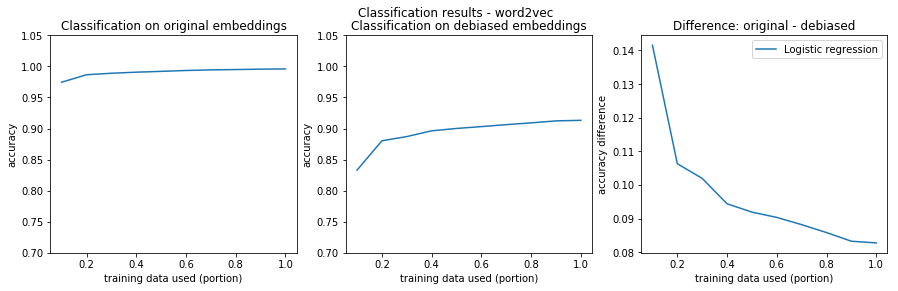

In [17]:
file = open('./code/lipstick//results/results_w2v')
results_js = file.read()
results = json.loads(results_js)
plot_results(results, "word2vec")

### Glove

Generate data

In [11]:
!cd ./code/lipstick/ && python3 classify_debiased.py --embeddings_original=../../embeddings/bias_glove.bin --embeddings_debiased=../../embeddings/debiased_glove.bin --fname=glove

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Number of words:  23177
Number of words:  23177
loading done
0.03978345669192328
0.0013121980356330023
================SVM - radial basis================

Data used (portion): 0.1

	train with bef
	test with bef
	accuracy: 0.9505
	train with aft
	test with aft
	accuracy: 0.7535
	train with bef
	test with bef
	accuracy: 0.9525
	train with aft
	test with aft
	accuracy: 0.84125
	train with bef
	test with bef
	accuracy: 0.94575
	train with aft
	test with aft
	accuracy: 0.8735
	train with bef
	test with bef
	accuracy: 0.95725
	train with aft
	test with aft
	accuracy: 0.86225
	train with bef
	test with bef
	accuracy: 

Show results

In [12]:
file = open('./code/lipstick//results/results_glove')
results_js = file.read()
results = json.loads(results_js)
plot_results(results, "glove")

b'\x80\x03]q\x00(X\x04\x00\x00\x00paidq\x01X\x08\x00\x00\x00inferiorq\x02X\x03\x00\x00\x00sayq\x03X\x08\x00\x00\x00imposingq\x04X\x07\x00\x00\x00recordsq\x05X\x04\x00\x00\x00dothq\x06X\x06\x00\x00\x00tuningq\x07X\x04\x00\x00\x00owedq\x08X\x08\x00\x00\x00downfallq\tX\x04\x00\x00\x00paceq\n'
b'X\x06\x00\x00\x00bowledq\x0bX\t\x00\x00\x00conqueredq\x0cX\t\x00\x00\x00attemptedq\rX\x06\x00\x00\x00greatsq\x0eX\x08\x00\x00\x00merchantq\x0fX\x0c\x00\x00\x00conservatismq\x10X\n'
b'\x00\x00\x00profitableq\x11X\x06\x00\x00\x00imposeq\x12X\x07\x00\x00\x00grenadeq\x13X\x0b\x00\x00\x00nationalistq\x14X\x04\x00\x00\x00theeq\x15X\x07\x00\x00\x00alumnusq\x16X\x05\x00\x00\x00chiefq\x17X\x05\x00\x00\x00henryq\x18X\t\x00\x00\x00fishermanq\x19X\n'
b'\x00\x00\x00undefeatedq\x1aX\x03\x00\x00\x00ptsq\x1bX\n'
b'\x00\x00\x00repentanceq\x1cX\t\x00\x00\x00primarilyq\x1dX\n'
b'\x00\x00\x00reboundingq\x1eX\x05\x00\x00\x00deityq\x1fX\x05\x00\x00\x00kevinq X\x03\x00\x00\x00axeq!X\x07\x00\x00\x00futuresq"X\n'
b"\x00\x0

NameError: name 'show_lipstic' is not defined